In [1]:
import numpy as np
import re
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/huanglinchun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/huanglinchun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/huanglinchun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
dfraw = pd.read_csv('./WELFake_Dataset.csv')
dfraw.drop('Unnamed: 0', axis = 1, inplace = True)

#### Remove Null Value

In [26]:
print('Before removal of null value:')
for col in dfraw.columns:
    print(f'  number of null value in column {col}= {dfraw[col].isnull().sum()}')
print(f'  Shape of data = {dfraw.shape}')
print('-------------------------------------------')
print('After')
dfraw = dfraw.dropna().reset_index().drop('index', axis = 1)
for col in dfraw.columns:
    print(f'  number of null value in column {col} = {dfraw[col].isnull().sum()}')
print(f'  Shape of data = {dfraw.shape}')

Before removal of null value:
  number of null value in column title= 558
  number of null value in column text= 39
  number of null value in column label= 0
  Shape of data = (72134, 3)
-------------------------------------------
After
  number of null value in column title = 0
  number of null value in column text = 0
  number of null value in column label = 0
  Shape of data = (71537, 3)


In [4]:
print('Before removal of blank value:')
for col in dfraw.columns:
    print(f'  number of blank value in column {col}= {(dfraw[col] == " ").sum()}')
print(f'  Shape of data = {dfraw.shape}')
print('-------------------------------------------')
print('After')
dfraw = dfraw.drop(dfraw[dfraw['text'] == " "].index).reset_index().drop('index', axis = 1)
for col in dfraw.columns:
    print(f'  number of blank value in column {col} = {(dfraw[col] == " ").sum()}')
print(f'  Shape of data = {dfraw.shape}')

Before removal of blank value:
  number of blank value in column title= 0
  number of blank value in column text= 738
  number of blank value in column label= 0
  Shape of data = (71537, 3)
-------------------------------------------
After
  number of blank value in column title = 0
  number of blank value in column text = 0
  number of blank value in column label = 0
  Shape of data = (70799, 3)


In [5]:
dfraw.head(10)

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
5,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,1
6,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",1
7,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",1
8,GOP Senator Just Smacked Down The Most Puncha...,The most punchable Alt-Right Nazi on the inter...,1
9,"May Brexit offer would hurt, cost EU citizens ...",BRUSSELS (Reuters) - British Prime Minister Th...,0


#### Remove Duplicated Row

In [27]:
print('Before removal of duplicated row:')
print(f'  number of duplicated row = {dfraw.duplicated().sum()}')
print(f'  shape = {dfraw.shape}')
print('-------------------------------------------')
print('After')
dfraw = dfraw.drop_duplicates()
print(f'  number of duplicated row = {dfraw.duplicated().sum()}')
print(f'  shape = {dfraw.shape}')

Before removal of duplicated row:
  number of duplicated row = 8416
  shape = (71537, 3)
-------------------------------------------
After
  number of duplicated row = 0
  shape = (63121, 3)


In [28]:
# in original data: label = 1 -> real
# we want label = 1 -> fake
dfraw['label'] = dfraw['label'].apply(lambda x: 1 - x)

#### Check if the dataset is balanced

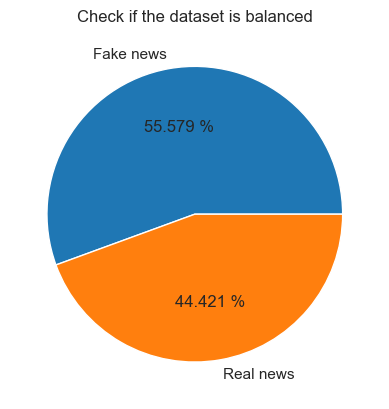

In [8]:
pie_label = dfraw.label.value_counts() / dfraw.label.count()
plt.pie(pie_label, labels = ['Fake news', 'Real news'], autopct = lambda x: f'{round(x, 3)} %');
plt.title('Check if the dataset is balanced');

#### Obtain only a subset of the dataset

In [9]:
fake = dfraw[dfraw['label'] == 1].sample(n = 5000, random_state = 1).reset_index()
real = dfraw[dfraw['label'] == 0].sample(n = 5000, random_state = 1).reset_index()
data = pd.concat([fake, real]).drop('index', axis = 1)

#### Text Preprocessing - tfidf vectorizer and transformer

In [13]:
stop_words = stopwords.words('english')
stopwords_to_append = ['said', 'say', 'would', 'mr', 'u']
for stopword in stopwords_to_append:
    stop_words.append(stopword)

def preprocessing(line):
    line = re.sub(r"[^a-zA-Z]", " ", line.lower())
    words = word_tokenize(line)
    words_lemmed = [WordNetLemmatizer().lemmatize(w) for w in words if w not in stop_words]
    words_removed_punct = [w for w in words_lemmed if w not in string.punctuation]

    return words_removed_punct

tfidf_vectorizer = TfidfVectorizer(tokenizer = preprocessing)

In [14]:
%%time
tfidf = tfidf_vectorizer.fit_transform(data['text']).toarray()
y = data['label']

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 20.6 s, sys: 509 ms, total: 21.1 s
Wall time: 21.5 s


In [15]:
print('Shape of the tfidf-Vectorized features (X)')
print(f'  (sample size, # No. of non-repeating tokens) = {tfidf.shape}')
print("Shape of y")
print(f'  {y.shape}')

Shape of the tfidf-Vectorized features (X)
  (sample size, # No. of non-repeating tokens) = (10000, 77107)
Shape of y
  (10000,)


#### Model training and selection

In [16]:
X_train, X_test, y_train, y_test = train_test_split(tfidf, y, test_size = 0.2)

##### Cross Validation

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
import time

models = [LogisticRegression(max_iter = 2000), 
          RandomForestClassifier(),
          MultinomialNB()]
model_names = ['Logistic Regression',
               'Random Forest Classifier',
               'Multinomial Naive Bayes']

scoring = ['precision', 'recall', 'f1_macro', 'roc_auc']
cross_val_df = pd.DataFrame(columns = scoring)

for model, name in zip(models, model_names):
    start_time = time.time()
    cv_return = cross_validate(estimator = model, 
                                       X = X_train, y = y_train, 
                                       scoring = scoring, cv = 3)
    cross_val_df.loc[name, 'precision'] = cv_return['test_precision'].mean()
    cross_val_df.loc[name, 'recall'] = cv_return['test_recall'].mean()
    cross_val_df.loc[name, 'f1_macro'] = cv_return['test_f1_macro'].mean()
    cross_val_df.loc[name, 'roc_auc'] = cv_return['test_roc_auc'].mean()
    stop_time = time.time()
    print(f'{name} trained, {round(stop_time - start_time, 3)} seconds used')

Logistic Regression trained, 19.726 seconds used
Random Forest Classifier trained, 74.463 seconds used
Multinomial Naive Bayes trained, 11.187 seconds used


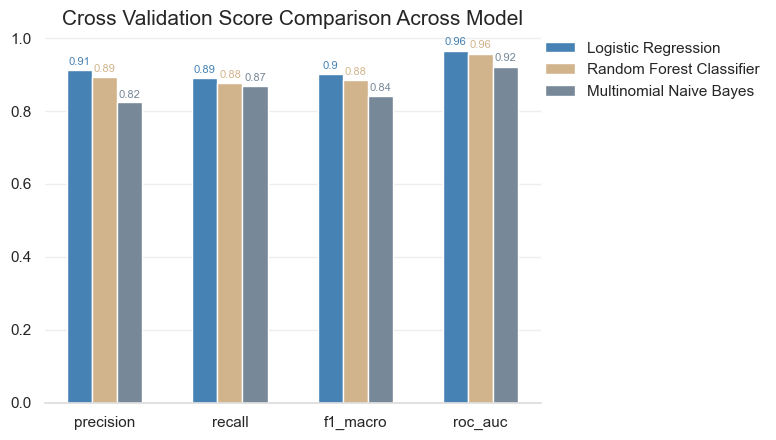

In [18]:
## Plot bar plots for Cross Validation Score
barwidth = 0.2
x = np.arange(len(cross_val_df.columns))

fig, ax = plt.subplots(1, 1)
ax.bar(x, cross_val_df.loc['Logistic Regression', :], width = barwidth, 
       label = 'Logistic Regression', color = 'steelblue')
ax.bar(x + 1 * barwidth, cross_val_df.loc['Random Forest Classifier', :], width = barwidth,
       label = 'Random Forest Classifier', color = 'tan')
ax.bar(x + 2 * barwidth, cross_val_df.loc['Multinomial Naive Bayes', :], width = barwidth,
       label = 'Multinomial Naive Bayes', color = 'lightslategrey')
ax.set_xticks(x + 1 * barwidth)
ax.set_xticklabels(cross_val_df.columns)

ax.legend(frameon = False, bbox_to_anchor=(1.47,0.9), loc = 'right')

def barStyling(bar):
       bar_value = bar.get_height()
       text = f'{round(bar_value, 2)}'
       text_x = bar.get_x() + bar.get_width() / 2
       text_y = (bar.get_y() + bar_value) * 1.01
       bar_color = bar.get_facecolor()
       ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color, size=8)
for bar in ax.patches:
       barStyling(bar)

def axesStyling(ax):
       ax.spines['top'].set_visible(False)
       ax.spines['right'].set_visible(False)
       ax.spines['left'].set_visible(False)
       ax.spines['bottom'].set_color('#DDDDDD')
       ax.tick_params(bottom=False, left=False)
       ax.set_axisbelow(True)
       ax.yaxis.grid(True, color='#EEEEEE')
       ax.xaxis.grid(False)
axesStyling(ax)

ax.set_title('Cross Validation Score Comparison Across Model', fontsize = 15);

##### Precision-Recall Curve and ROC

In [19]:
from sklearn.metrics import precision_recall_curve, roc_curve
def valsPrecisionRecallCurve(model):
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob[:,1])
    return precisions, recalls
def plotPrecisionRecallCurve(precisions, recalls, label, ax, color):
    ax.plot(precisions, recalls, label = f'{label}', color = color)
    ax.set_xlabel('Precision')
    ax.set_ylabel('Recall')
def valsROCCurve(model):
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
    return fpr, tpr
def plotROCCurve(fpr, tpr, label, ax, color):
    ax.plot(fpr, tpr, label = f'{label}', color = color)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

In [20]:
prc_dict = {}
for model, name in zip(models, model_names):
    begin = time.time()
    precisions, recalls = valsPrecisionRecallCurve(model)
    prc_dict[name] = (precisions, recalls)
    end = time.time()

    print(f'''{name} trained and Precision Recall Curve data obtained. 
          {round(end-begin,3)} seconds used.''')

Logistic Regression trained and Precision Recall Curve data obtained. 
          24.449 seconds used.
Random Forest Classifier trained and Precision Recall Curve data obtained. 
          36.027 seconds used.
Multinomial Naive Bayes trained and Precision Recall Curve data obtained. 
          4.057 seconds used.


In [21]:
roc_dict = {}
for model, name in zip(models, model_names):
    begin = time.time()
    fpr, tpr = valsROCCurve(model)
    roc_dict[name] = (fpr, tpr)
    end = time.time()

    print(f'''{name} trained and ROC Curve data obtained. 
          {round(end-begin,3)} seconds used.''')

Logistic Regression trained and ROC Curve data obtained. 
          22.399 seconds used.
Random Forest Classifier trained and ROC Curve data obtained. 
          35.623 seconds used.
Multinomial Naive Bayes trained and ROC Curve data obtained. 
          4.004 seconds used.


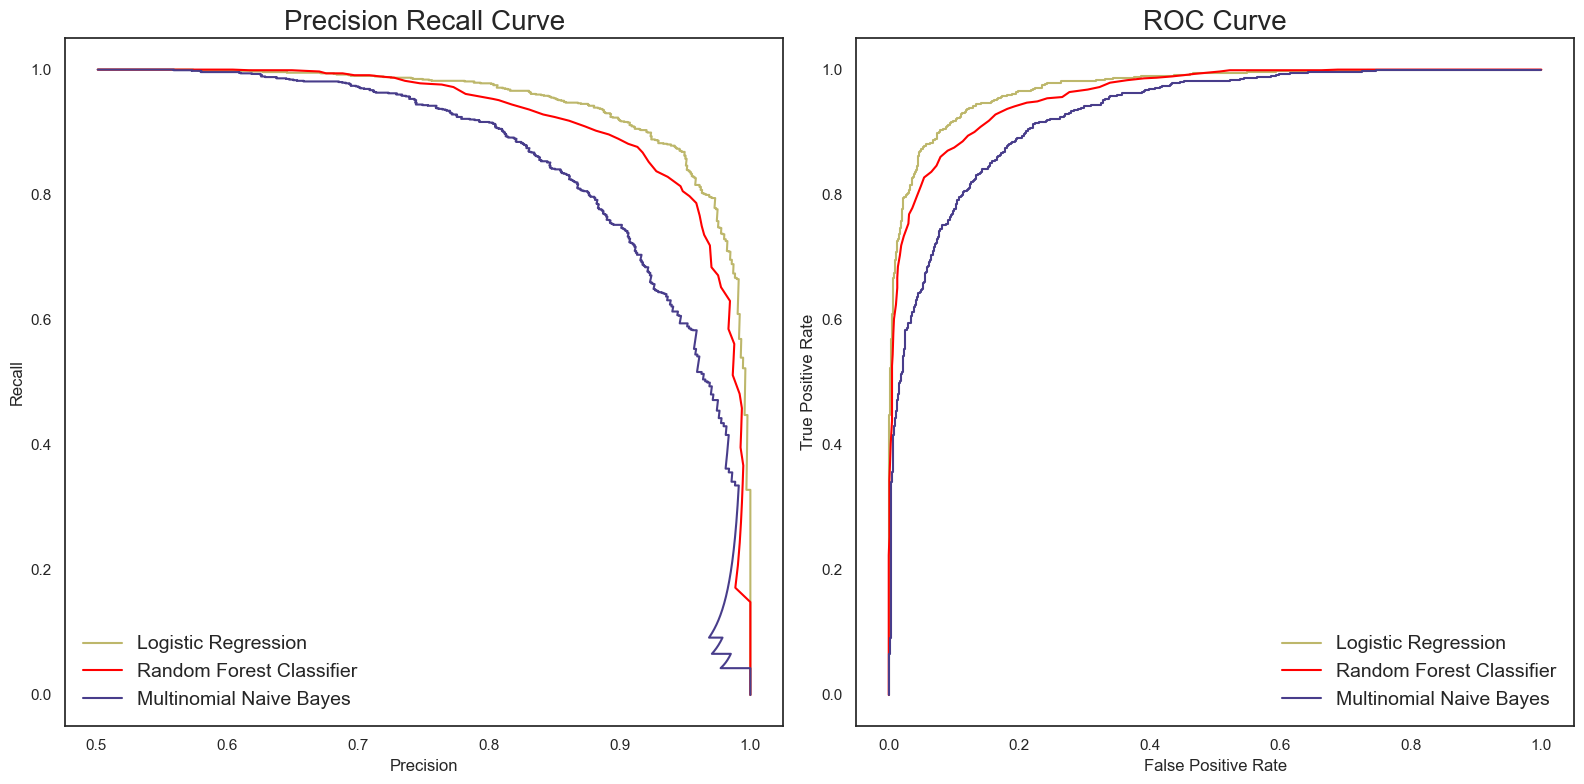

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))
color_list = ['darkkhaki', 'red', 'darkslateblue', 'darkseagreen']

for model, name, color in zip(models, model_names, color_list):
    plotPrecisionRecallCurve(prc_dict[name][0], prc_dict[name][1], name, ax = ax1, color = color)
    plotROCCurve(roc_dict[name][0], roc_dict[name][1], name, ax = ax2, color = color)
ax1.legend(frameon = False, fontsize= 14)
ax1.set_title('Precision Recall Curve', fontsize = 20)
ax2.legend(frameon = False, fontsize= 14)
ax2.set_title('ROC Curve', fontsize = 20)


fig.tight_layout()

##### Confusion Matrix

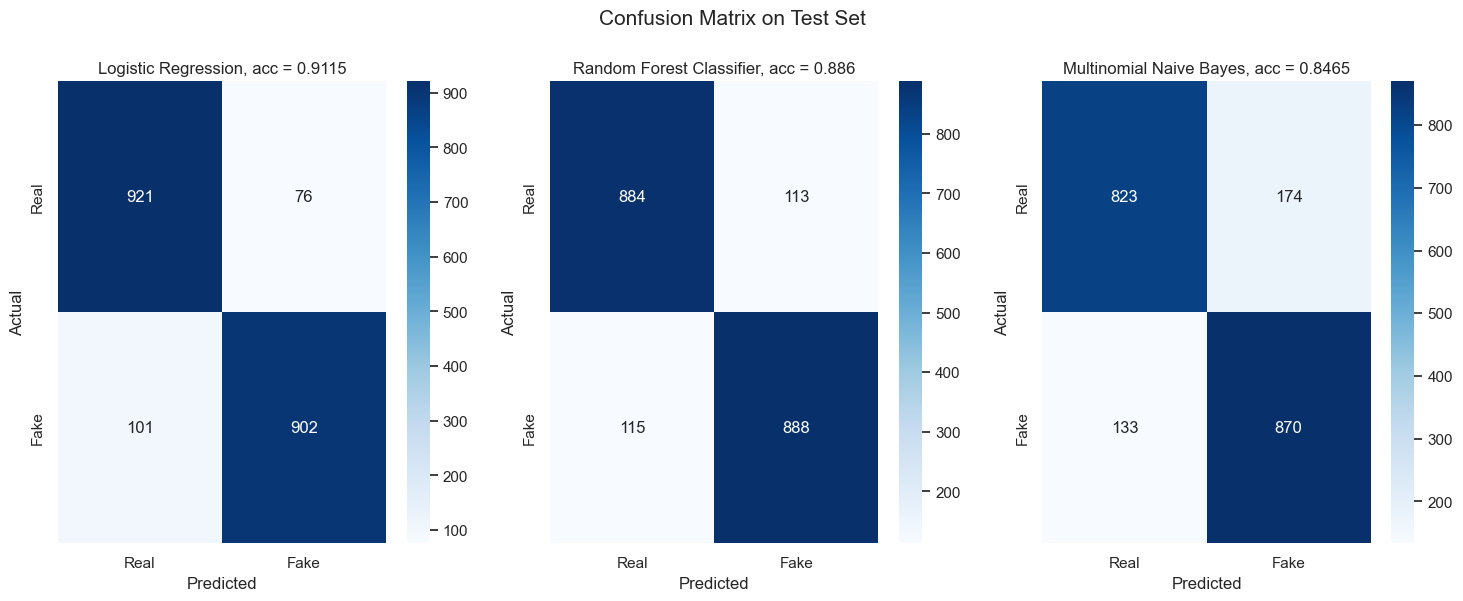

In [34]:
from sklearn.metrics import confusion_matrix
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 6))
for name, model, ax in zip(model_names, models, [ax1, ax2, ax3]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot= True, fmt = 'g', cmap = sns.color_palette("Blues", as_cmap=True), ax = ax);
    ax.set_xticklabels(['Real', 'Fake']);
    ax.set_yticklabels(['Real', 'Fake']);
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
    acc = (cm[0, 0] + cm[1, 1])/(cm[0, 0] + cm[0, 1] + cm[1, 0] + cm[1, 1])
    ax.set_title(f'{name}, acc = {acc}');
fig.suptitle('Confusion Matrix on Test Set', y = 1, fontsize = 15);

In [29]:
%%time
# Clean the raw data and save data with tokens to a new file
dfraw['tokens'] = dfraw.text.apply(preprocessing)
dfraw.to_csv('tokenized_data.csv')

CPU times: user 2min 6s, sys: 1.37 s, total: 2min 8s
Wall time: 2min 9s


In [39]:
# Hyper parameter tuning for Logistic Regression
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression(max_iter = 2000)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

begin = time.time()
GS_logistic = GridSearchCV(estimator = clf, param_grid = param_grid).fit(X_train, y_train)
end = time.time()

print(f"Grid Search Hyper parameter tuning is completed. {round(end-begin, 3)} secs used.")

Grid Search Hyper parameter tuning is completed. 418.68 secs used.


!! EDA and Topic Modeling are in another ipynb file

In [50]:
GS_logistic.best_params_

{'C': 10}

In [73]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

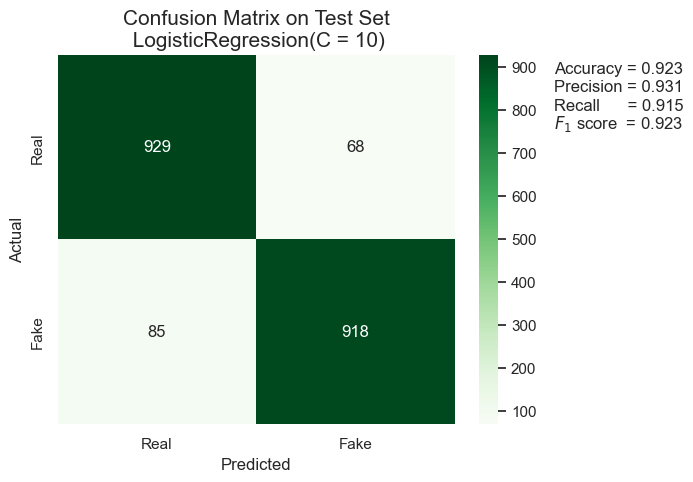

In [88]:
y_pred = GS_logistic.best_estimator_.predict(X_test)
fig, ax = plt.subplots(1, 1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot= True, fmt = 'g', cmap = sns.color_palette("Greens", as_cmap=True), ax = ax);
ax.set_xticklabels(['Real', 'Fake']);
ax.set_yticklabels(['Real', 'Fake']);
ax.set_xlabel('Predicted');
ax.set_ylabel('Actual');

ax.text(2.5, 0.1, f'Accuracy = {round(accuracy_score(y_test, y_pred),3)}');
ax.text(2.5, 0.2, f'Precision = {round(precision_score(y_test, y_pred),3)}');
ax.text(2.5, 0.3, f'Recall      = {round(recall_score(y_test, y_pred),3)}');
ax.text(2.5, 0.4, f'$F_1$ score  = {round(f1_score(y_test, y_pred),3)}');

ax.set_title("Confusion Matrix on Test Set\n LogisticRegression(C = 10)",
             fontsize = 15);
